In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
from torchvision import models
from torch import nn
from torch import optim

In [2]:
nan_val = -32768.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train_chips = '/home/oqbrady/data/data/chips/train/'
val_chips = '/home/oqbrady/data/data/chips/validation/'
train_files = os.listdir('/home/oqbrady/data/data/chips/train/')
val_scenes = os.listdir(val_chips)
train_scences = os.listdir(train_chips)

In [4]:
inference_scenes = pd.read_csv('inference_scenes.csv')
inference = inference_scenes['0'].to_list()

In [5]:
pos_image_path = '/home/oqbrady/data/data/sub_boxes/positives_v3/'
neg_image_path = '/home/oqbrady/data/data/sub_boxes/negatives/'

In [6]:
labels_train = pd.read_csv("labels_v4_train.csv")
# labels_val = pd.read_csv("labels_v3_val.csv")

In [7]:
names = ['bay_mean', 'vh_mean', 'vh_max', 'vv_max', 'vh_min', 'vv_min', 'land', 'NaN', 'label', 'scene', 'chip', 'num']
neg_samples = pd.read_csv("negative_chip_vals.csv", names=names)

In [8]:
neg_samples = neg_samples.drop(np.nan)

In [9]:
neg_samples.shape

(1937374, 12)

In [10]:
# bst = xgb.Booster()  # init model
# bst.load_model('gbt_v1.model')  # load data
# test = neg_samples.drop(labels=['label', 'scene', 'chip', 'num'], axis=1)
# dtest = xgb.DMatrix(test)
# ypred = bst.predict(dtest)
# predictions = ypred > 0.5
# neg_samples['preds'] = predictions
# pos_neg_samples = neg_samples[neg_samples['preds'] == 1]

In [11]:
pos_neg_samples = pd.read_csv("positive_negative_samples.csv")

In [12]:
df_gbt = pd.read_csv("train_GBT.csv", names=names[:-3])

In [13]:
df_means = df_gbt.copy()

In [14]:
df_gbt

,bay_mean,vh_mean,vh_max,vv_max,vh_min,vv_min,land,NaN,label
0,-99.964500,-30.477900,-26.203125,-13.328125,-37.12500,-30.203125,0.0,0.0,0.0
1,-3594.778809,-28.181025,-24.625000,-15.484375,-34.87500,-32.562500,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,1.0,0.0,0.0
3,-39.001675,-28.543694,-23.734375,-17.656250,-37.31250,-32.468750,0.0,0.0,0.0
4,-46.351612,-29.431162,-25.296875,-15.976562,-39.18750,-29.562500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1807139,-68.119278,-31.918276,-25.437500,-12.796875,-39.28125,-22.750000,0.0,0.0,0.0
1807140,-117.068878,-28.421625,-24.593750,-19.500000,-35.87500,-35.781250,0.0,0.0,0.0
1807141,-4764.534180,-32.727139,-27.000000,-21.421875,-38.81250,-35.125000,0.0,0.0,0.0
1807142,-125.340927,-30.516380,-25.765625,-13.593750,-37.43750,-27.921875,0.0,0.0,0.0


In [15]:
df_means[(df_means['NaN'] == 0)]['bay_mean'].std()

1674.5504056349082

In [16]:
df_means[(df_means['NaN'] == 0)]['bay_mean'].std()

1674.5504056349082

In [17]:
min_vh = df_means[df_means['vh_min'] != nan_val]['vh_min'].min()
min_vv = df_means[df_means['vv_min'] != nan_val]['vv_min'].min()
min_bay = df_means[(df_means['bay_mean'] != nan_val) & (df_means['NaN'] == 0)]['bay_mean'].min()

In [18]:
mean_vh = df_means[df_means['NaN'] != 1]['vh_mean'].mean()
mean_vv = -15 #df_means[df_means['NaN'] != 1]['vv_mean'].mean()
mean_bay = df_means[df_means['NaN'] != 1]['bay_mean'].mean()

In [19]:
std_vh = 7.4
std_vv = 5.15
std_bay = 1600

In [20]:
image_paths = []
labels = []

In [21]:
base = neg_image_path
for i in range(pos_neg_samples.shape[0]):
    row = pos_neg_samples.iloc[i]
    fl = base + row['scene'] + '_' + str(row['chip']) + '_' + str(row['num'])
    image_paths.append(fl)
    labels.append(0)

In [22]:
neg_imges_list = os.listdir(neg_image_path)

In [23]:
base = neg_image_path
for fl in neg_imges_list[:50000]:
    image_paths.append(base + fl)
    labels.append(0)

In [24]:
base = pos_image_path
for i in range(labels_train.shape[0]):
    row = labels_train.iloc[i]
    fl = base + row['scene'] + '_' + str(row['chip']) + '_' + str(row['num'])
    image_paths.append(fl)
    labels.append(row['labels'])

In [25]:
base = '/home/oqbrady/data/data/sub_boxes/inference/'
images = [base + x for x in os.listdir(base)]
image_paths.extend(images)
labels.extend([0] * len(images))

In [26]:
class SARImagery(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.images[idx]
        num = img_name.split("_")[-1]
        vh = np.load(img_name + '/' + num + '_vh.npy')
        vv = np.load(img_name + '/' + num + '_vv.npy')
        bay = np.load(img_name + '/' + num + '_bay.npy')
        image = np.array((vv, vh, bay))
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        image = torch.from_numpy(image)
        if torch.isnan(image).any():
            image= torch.zeros((3, 50, 50))
        return (image.to(device), torch.tensor(label).to(device))

In [27]:
class drop_nans(object):
    def __call__(self, image):
        image[0, :, :][image[0, :, :] == -32768.] = min_vh - 10
        image[1, :, :][image[1, :, :] == -32768.] = min_vv - 10
        image[2, :, :][image[2, :, :] == -32768.] = min_bay - 100
        return image

class norm(object):
    def __call__(self, image):
        image[0, :, :] = (image[0, :, :] - mean_vh) / std_vh
        image[1, :, :] = (image[1, :, :] - mean_vv) / std_vv
        image[2, :, :] = (image[2, :, :] - mean_bay) / std_bay
        return image

In [28]:
transform = transforms.Compose(
    [drop_nans(),
    norm()])

In [29]:
dataset = SARImagery(image_paths, labels, transform=transform)

In [30]:
train_len = int(len(dataset) * 0.85)
val_len = len(dataset) - train_len

In [31]:
train_data, val_data = torch.utils.data.random_split(dataset, lengths=[train_len,val_len])

In [32]:
labels_np = np.array(labels)

In [33]:
class_counts = np.unique(labels_np, return_counts=True)[1]

In [34]:
class_percent = class_counts / labels_np.shape[0]

In [35]:
weights = 1 / class_percent

In [36]:
class_percent

array([0.59778445, 0.09534286, 0.18158367, 0.12528902])

In [38]:
net = models.resnet18(pretrained=True)
net.fc = nn.Linear(in_features=512, out_features=4, bias=True)
net.load_state_dict(torch.load('saved_models/resnet9.pth'))
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Dataset Prep

In [39]:
batch_size = 8
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True)

valloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                         shuffle=True)

In [42]:
print(len(train_data), len(val_data))

98521 17387


In [41]:
w = torch.tensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=w.float())
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [44]:
best_model = ""
min_val = 1

In [45]:
train_l = []
val_l = []

In [ ]:
base = 0
for epoch in range(1, 100):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    run_tot_loss = 0.0
    j = 0
    for i, data in tqdm(enumerate(trainloader, 0)):
#         get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        outputs = net(inputs)
        optimizer.zero_grad()
#         print(outputs)
#         print(labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        run_tot_loss += loss.item()
        running_loss += loss.item()
        if i % 1000 == 999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0
        j += 1
    train_l.append(run_tot_loss / j)
    running_val_loss = 0
    correct = 0
    total = 0
    torch.save(net.state_dict(), 'saved_models/resnet_more_neg_' + str(epoch + base) + '.pth')
    k = 0
    net.eval()
    for j, data  in enumerate(valloader):
        k+=1
        images, labels = data
        with torch.no_grad():
            outputs = net(images)
            preds = torch.argmax(nn.functional.softmax(outputs, dim=1), dim=1)
            correct += (preds == labels).sum()
            total += labels.shape[0]
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    print("val_loss", running_val_loss / k)
    val_l.append(running_val_loss / k)
    print("Val accuracy", correct / total)
    val_loss = running_val_loss / k
    if val_loss < min_val:
        min_val = val_loss
        best_model = net
        best_epoch = epoch
print('Finished Training')

1000it [09:28,  1.87it/s]

[2,  1000] loss: 0.894


2000it [18:13,  1.98it/s]

[2,  2000] loss: 0.672


3000it [26:37,  1.87it/s]

[2,  3000] loss: 0.599


4000it [34:43,  2.01it/s]

[2,  4000] loss: 0.555


5000it [42:43,  2.14it/s]

[2,  5000] loss: 0.537


6000it [50:29,  2.19it/s]

[2,  6000] loss: 0.500


7000it [58:11,  2.20it/s]

[2,  7000] loss: 0.493


8000it [1:05:45,  2.02it/s]

[2,  8000] loss: 0.474


9000it [1:13:18,  2.25it/s]

[2,  9000] loss: 0.474


10000it [1:20:48,  2.19it/s]

[2, 10000] loss: 0.450


11000it [1:28:20,  2.01it/s]

[2, 11000] loss: 0.454


12000it [1:35:54,  2.31it/s]

[2, 12000] loss: 0.445


12316it [1:38:16,  2.09it/s]


val_loss 0.38824357739401244
Val accuracy tensor(0.9054, device='cuda:0')


1001it [02:56,  5.74it/s]

[3,  1000] loss: 0.416


2001it [05:51,  5.76it/s]

[3,  2000] loss: 0.385


3001it [08:47,  5.71it/s]

[3,  3000] loss: 0.390


4001it [11:42,  5.80it/s]

[3,  4000] loss: 0.387


5001it [14:38,  5.68it/s]

[3,  5000] loss: 0.378


6001it [17:33,  5.69it/s]

[3,  6000] loss: 0.386


7001it [20:29,  5.77it/s]

[3,  7000] loss: 0.374


8001it [23:25,  5.73it/s]

[3,  8000] loss: 0.360


9001it [26:21,  5.67it/s]

[3,  9000] loss: 0.380


10001it [29:16,  5.72it/s]

[3, 10000] loss: 0.377


11001it [32:12,  5.67it/s]

[3, 11000] loss: 0.373


12001it [35:07,  5.70it/s]

[3, 12000] loss: 0.370


12316it [36:02,  5.69it/s]


val_loss 0.3857314982508796
Val accuracy tensor(0.9051, device='cuda:0')


1001it [02:55,  5.75it/s]

[4,  1000] loss: 0.323


2001it [05:50,  5.72it/s]

[4,  2000] loss: 0.335


3001it [08:45,  5.63it/s]

[4,  3000] loss: 0.340


4001it [11:41,  5.65it/s]

[4,  4000] loss: 0.343


5001it [14:37,  5.70it/s]

[4,  5000] loss: 0.349


6001it [17:32,  5.73it/s]

[4,  6000] loss: 0.328


7001it [20:27,  5.75it/s]

[4,  7000] loss: 0.327


8001it [23:23,  5.62it/s]

[4,  8000] loss: 0.334


9001it [26:18,  5.67it/s]

[4,  9000] loss: 0.341


10001it [29:13,  5.80it/s]

[4, 10000] loss: 0.349


11001it [32:08,  5.69it/s]

[4, 11000] loss: 0.320


12001it [35:03,  5.79it/s]

[4, 12000] loss: 0.326


12316it [35:58,  5.71it/s]


val_loss 0.31910034279410665
Val accuracy tensor(0.9255, device='cuda:0')


1001it [02:55,  5.70it/s]

[5,  1000] loss: 0.317


2001it [05:51,  5.60it/s]

[5,  2000] loss: 0.305


3001it [08:46,  5.74it/s]

[5,  3000] loss: 0.304


4001it [11:42,  5.71it/s]

[5,  4000] loss: 0.280


5001it [14:38,  5.76it/s]

[5,  5000] loss: 0.298


6000it [19:15,  1.68it/s]

[5,  6000] loss: 0.320


7000it [28:15,  1.96it/s]

[5,  7000] loss: 0.294


8000it [37:00,  1.64it/s]

[5,  8000] loss: 0.309


9000it [45:47,  1.94it/s]

[5,  9000] loss: 0.303


10000it [54:26,  1.98it/s]

[5, 10000] loss: 0.296


11000it [1:03:07,  1.84it/s]

[5, 11000] loss: 0.320


12000it [1:11:38,  1.96it/s]

[5, 12000] loss: 0.304


12316it [1:14:17,  2.76it/s]


val_loss 0.3422344764229767
Val accuracy tensor(0.9213, device='cuda:0')


1000it [07:28,  2.29it/s]

[6,  1000] loss: 0.291


2000it [14:55,  2.44it/s]

[6,  2000] loss: 0.274


3000it [22:27,  2.02it/s]

[6,  3000] loss: 0.288


4000it [30:26,  2.26it/s]

[6,  4000] loss: 0.263


5000it [38:26,  2.01it/s]

[6,  5000] loss: 0.275


6000it [46:08,  2.56it/s]

[6,  6000] loss: 0.261


7000it [53:45,  1.85it/s]

[6,  7000] loss: 0.279


8000it [1:01:40,  1.85it/s]

[6,  8000] loss: 0.279


9000it [1:09:17,  2.08it/s]

[6,  9000] loss: 0.281


10000it [1:16:58,  2.23it/s]

[6, 10000] loss: 0.274


11000it [1:25:31,  2.16it/s]

[6, 11000] loss: 0.271


12000it [1:33:55,  2.14it/s]

[6, 12000] loss: 0.277


12316it [1:36:27,  2.13it/s]


val_loss 0.33848951440518477
Val accuracy tensor(0.9231, device='cuda:0')


1000it [07:02,  2.49it/s]

[7,  1000] loss: 0.239


2000it [14:01,  1.96it/s]

[7,  2000] loss: 0.261


3000it [20:55,  2.54it/s]

[7,  3000] loss: 0.256


4000it [27:49,  2.41it/s]

[7,  4000] loss: 0.246


5000it [34:43,  2.43it/s]

[7,  5000] loss: 0.246


6000it [42:01,  2.22it/s]

[7,  6000] loss: 0.252


7000it [49:10,  2.48it/s]

[7,  7000] loss: 0.259


8000it [56:10,  1.97it/s]

[7,  8000] loss: 0.242


9000it [1:03:01,  2.70it/s]

[7,  9000] loss: 0.258


10000it [1:09:47,  2.55it/s]

[7, 10000] loss: 0.264


11000it [1:16:24,  2.72it/s]

[7, 11000] loss: 0.262


12000it [1:23:02,  2.72it/s]

[7, 12000] loss: 0.252


12316it [1:25:06,  2.41it/s]


val_loss 0.2919797863035438
Val accuracy tensor(0.9329, device='cuda:0')


1000it [05:13,  3.11it/s]

[8,  1000] loss: 0.213


2000it [10:26,  3.20it/s]

[8,  2000] loss: 0.203


3000it [15:40,  3.16it/s]

[8,  3000] loss: 0.246


4000it [20:52,  3.11it/s]

[8,  4000] loss: 0.227


5000it [26:06,  3.30it/s]

[8,  5000] loss: 0.222


6000it [31:18,  3.04it/s]

[8,  6000] loss: 0.236


7000it [36:31,  3.63it/s]

[8,  7000] loss: 0.230


8000it [41:47,  3.16it/s]

[8,  8000] loss: 0.243


9000it [47:01,  2.67it/s]

[8,  9000] loss: 0.229


10000it [52:16,  3.32it/s]

[8, 10000] loss: 0.229


11000it [57:29,  3.21it/s]

[8, 11000] loss: 0.225


12000it [1:02:39,  3.07it/s]

[8, 12000] loss: 0.239


12316it [1:04:17,  3.19it/s]


val_loss 0.2867442425656595
Val accuracy tensor(0.9328, device='cuda:0')


1001it [02:56,  5.73it/s]

[9,  1000] loss: 0.192


2001it [05:52,  5.61it/s]

[9,  2000] loss: 0.212


3001it [08:49,  5.65it/s]

[9,  3000] loss: 0.197


4001it [11:45,  5.65it/s]

[9,  4000] loss: 0.194


5001it [14:42,  5.65it/s]

[9,  5000] loss: 0.215


6001it [17:38,  5.62it/s]

[9,  6000] loss: 0.211


7001it [20:34,  5.72it/s]

[9,  7000] loss: 0.203


8001it [23:31,  5.66it/s]

[9,  8000] loss: 0.201


9001it [26:27,  5.70it/s]

[9,  9000] loss: 0.221


10001it [29:24,  5.72it/s]

[9, 10000] loss: 0.213


11001it [32:20,  5.64it/s]

[9, 11000] loss: 0.207


12001it [35:16,  5.74it/s]

[9, 12000] loss: 0.204


12316it [36:12,  5.67it/s]


val_loss 0.30513310675754624
Val accuracy tensor(0.9283, device='cuda:0')


1001it [02:56,  5.59it/s]

[10,  1000] loss: 0.173


2001it [05:52,  5.67it/s]

[10,  2000] loss: 0.185


3001it [08:48,  5.70it/s]

[10,  3000] loss: 0.174


4001it [11:44,  5.75it/s]

[10,  4000] loss: 0.181


5001it [14:40,  5.63it/s]

[10,  5000] loss: 0.181


6001it [17:35,  5.73it/s]

[10,  6000] loss: 0.199


7001it [20:31,  5.59it/s]

[10,  7000] loss: 0.169


8001it [23:27,  5.64it/s]

[10,  8000] loss: 0.193


9001it [26:23,  5.65it/s]

[10,  9000] loss: 0.179


10001it [29:19,  5.63it/s]

[10, 10000] loss: 0.176


11001it [32:15,  5.64it/s]

[10, 11000] loss: 0.173


12001it [35:11,  5.59it/s]

[10, 12000] loss: 0.186


12316it [36:07,  5.68it/s]


val_loss 0.37092371490982234
Val accuracy tensor(0.9245, device='cuda:0')


1001it [02:56,  5.61it/s]

[11,  1000] loss: 0.147


2001it [05:52,  5.68it/s]

[11,  2000] loss: 0.163


3001it [08:49,  5.71it/s]

[11,  3000] loss: 0.167


4001it [11:46,  5.62it/s]

[11,  4000] loss: 0.159


5001it [14:42,  5.67it/s]

[11,  5000] loss: 0.157


6001it [17:39,  5.73it/s]

[11,  6000] loss: 0.158


7001it [20:35,  5.65it/s]

[11,  7000] loss: 0.150


8001it [23:32,  5.67it/s]

[11,  8000] loss: 0.149


9001it [26:28,  5.58it/s]

[11,  9000] loss: 0.169


10001it [29:24,  5.66it/s]

[11, 10000] loss: 0.160


11001it [32:21,  5.63it/s]

[11, 11000] loss: 0.165


12001it [35:17,  5.69it/s]

[11, 12000] loss: 0.174


12316it [36:13,  5.67it/s]


val_loss 0.424784281074684
Val accuracy tensor(0.9185, device='cuda:0')


1001it [02:56,  5.70it/s]

[12,  1000] loss: 0.131


2001it [05:52,  5.70it/s]

[12,  2000] loss: 0.130


3001it [08:47,  5.68it/s]

[12,  3000] loss: 0.147


4001it [11:43,  5.77it/s]

[12,  4000] loss: 0.126


5001it [14:39,  5.79it/s]

[12,  5000] loss: 0.133


6001it [17:35,  5.68it/s]

[12,  6000] loss: 0.137


7001it [20:31,  5.69it/s]

[12,  7000] loss: 0.141


8001it [23:26,  5.65it/s]

[12,  8000] loss: 0.136


9001it [26:22,  5.75it/s]

[12,  9000] loss: 0.164


10001it [29:18,  5.66it/s]

[12, 10000] loss: 0.138


11001it [32:14,  5.64it/s]

[12, 11000] loss: 0.155


12001it [35:10,  5.63it/s]

[12, 12000] loss: 0.152


12316it [36:06,  5.69it/s]


val_loss 0.322671473099979
Val accuracy tensor(0.9301, device='cuda:0')


1001it [02:56,  5.68it/s]

[13,  1000] loss: 0.103


2001it [05:53,  5.61it/s]

[13,  2000] loss: 0.112


3001it [08:50,  5.63it/s]

[13,  3000] loss: 0.120


4001it [11:46,  5.66it/s]

[13,  4000] loss: 0.119


5001it [14:43,  5.60it/s]

[13,  5000] loss: 0.129


6001it [17:40,  5.58it/s]

[13,  6000] loss: 0.131


7001it [20:37,  5.72it/s]

[13,  7000] loss: 0.133


8001it [23:34,  5.76it/s]

[13,  8000] loss: 0.121


9001it [26:31,  5.65it/s]

[13,  9000] loss: 0.121


10001it [29:27,  5.69it/s]

[13, 10000] loss: 0.128


11001it [32:24,  5.77it/s]

[13, 11000] loss: 0.139


12001it [35:20,  5.74it/s]

[13, 12000] loss: 0.137


12316it [36:16,  5.66it/s]


val_loss 0.356063477030781
Val accuracy tensor(0.9308, device='cuda:0')


1001it [02:56,  5.71it/s]

[14,  1000] loss: 0.087


2001it [05:52,  5.68it/s]

[14,  2000] loss: 0.106


3001it [08:48,  5.70it/s]

[14,  3000] loss: 0.107


4001it [11:43,  5.70it/s]

[14,  4000] loss: 0.092


5001it [14:39,  5.69it/s]

[14,  5000] loss: 0.108


6001it [17:34,  5.72it/s]

[14,  6000] loss: 0.114


7001it [20:30,  5.67it/s]

[14,  7000] loss: 0.104


8001it [23:26,  5.68it/s]

[14,  8000] loss: 0.115


9001it [26:22,  5.67it/s]

[14,  9000] loss: 0.126


10001it [29:18,  5.69it/s]

[14, 10000] loss: 0.121


11001it [32:13,  5.71it/s]

[14, 11000] loss: 0.106


12001it [35:09,  5.76it/s]

[14, 12000] loss: 0.116


12316it [36:04,  5.69it/s]


val_loss 0.40995052666618303
Val accuracy tensor(0.9245, device='cuda:0')


1001it [02:56,  5.62it/s]

[15,  1000] loss: 0.080


2001it [05:52,  5.65it/s]

[15,  2000] loss: 0.092


3001it [08:48,  5.68it/s]

[15,  3000] loss: 0.097


4001it [11:45,  5.68it/s]

[15,  4000] loss: 0.093


5001it [14:42,  5.64it/s]

[15,  5000] loss: 0.092


6001it [17:39,  5.65it/s]

[15,  6000] loss: 0.087


7001it [20:35,  5.64it/s]

[15,  7000] loss: 0.098


8001it [23:32,  5.73it/s]

[15,  8000] loss: 0.114


9001it [26:28,  5.55it/s]

[15,  9000] loss: 0.088


10001it [29:24,  5.72it/s]

[15, 10000] loss: 0.094


11001it [32:20,  5.64it/s]

[15, 11000] loss: 0.099


12001it [35:17,  5.66it/s]

[15, 12000] loss: 0.098


12316it [36:12,  5.67it/s]


val_loss 0.4250430212477621
Val accuracy tensor(0.9252, device='cuda:0')


1001it [02:56,  5.59it/s]

[16,  1000] loss: 0.064


2001it [05:52,  5.69it/s]

[16,  2000] loss: 0.083


2548it [07:28,  5.64it/s]

In [ ]:
# best model == 

In [98]:
os.listdir("/home/oqbrady/data/data/sub_boxes/")

['positives_v3',
 'inference',
 'negatives_v2',
 'positives_v2',
 'positives',
 'negatives']

In [46]:
preds_all = []
correct_all = []
correct = 0
total = 0
false_negs = []
false_neg_labels = []
false_pos = []
false_pos_labels = []
running_val_loss = 0
for j, data  in tqdm(enumerate(valloader)):
    images, labels = data
    with torch.no_grad():
        outputs = net(images)
        soft = nn.functional.softmax(outputs, dim=1)
#         print(soft)
#         soft[:, 1] = soft[:, 1] + 0.9
#         print(soft)
        preds = torch.argmax(soft, dim=1)
        preds_all.append(preds.detach().cpu().numpy())
        correct_all.append(labels.detach().cpu().numpy())
        correct += (preds == labels).sum()
        total += labels.shape[0]
        loss = criterion(outputs, labels)
        running_val_loss += loss.item()
        idx = 0
        for x, y in zip(preds, labels):
            if (x == 0) and((y == 1) or (y == 2) or (y == 3)):
                false_negs.append(images[idx].detach().cpu().numpy())
                false_neg_labels.append(y)
            if (y == 0) and((x == 1) or (x == 2) or (x == 3)):
                false_pos.append(images[idx].detach().cpu().numpy())
                false_pos_labels.append(x)
        idx += 1
print("test_loss", running_val_loss / j)
print("test accuracy", correct / total)

2174it [18:26,  1.97it/s]


test_loss 0.21030282618905885
test accuracy tensor(0.9536, device='cuda:0')


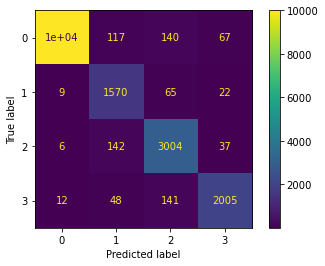

In [47]:
x = confusion_matrix(np.concatenate(correct_all), np.concatenate(preds_all))
ConfusionMatrixDisplay(x).plot()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


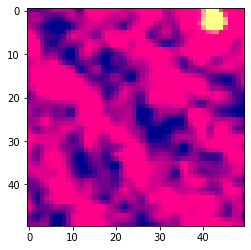

In [64]:
plt.imshow(false_pos[12].transpose(1, 2, 0), cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


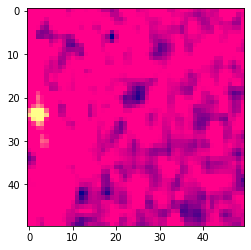

In [72]:
plt.imshow(false_negs[0].transpose(1, 2, 0), cmap='gray', vmin=-1, vmax=1)

In [51]:
false_pos[1].transpose(1, 2, 0)

array([[[-4.679343 , -8.525485 ,  1.1445951],
        [-4.679343 , -8.525485 ,  1.1431758],
        [-4.679343 , -8.525485 ,  1.1417564],
        ...,
        [-4.679343 , -8.525485 ,  1.0857247],
        [-4.679343 , -8.525485 ,  1.0852287],
        [-4.679343 , -8.525485 ,  1.0847327]],

       [[-4.679343 , -8.525485 ,  1.1440903],
        [-4.679343 , -8.525485 ,  1.1426717],
        [-4.679343 , -8.525485 ,  1.141253 ],
        ...,
        [-4.679343 , -8.525485 ,  1.0852509],
        [-4.679343 , -8.525485 ,  1.0847551],
        [-4.679343 , -8.525485 ,  1.0842594]],

       [[-4.679343 , -8.525485 ,  1.1435853],
        [-4.679343 , -8.525485 ,  1.1421676],
        [-4.679343 , -8.525485 ,  1.1407496],
        ...,
        [-4.679343 , -8.525485 ,  1.0847771],
        [-4.679343 , -8.525485 ,  1.0842814],
        [-4.679343 , -8.525485 ,  1.083786 ]],

       ...,

       [[-4.679343 , -8.525485 ,  1.1192801],
        [-4.679343 , -8.525485 ,  1.1179614],
        [-4.679343 , -